In [1]:
import argparse
import cvxpy as cp
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

device = "cuda"

In [2]:
def get_rand_mean_sigma(d):
    mu        = np.random.rand(d)
    sigma_tmp = np.random.rand(d, d)
    sigma     = np.dot(sigma_tmp, sigma_tmp.transpose())
    return mu, sigma

In [3]:
# distribution parameters need to be fixed for the simulation
mu_G, sigma_G = get_rand_mean_sigma(5)
mu_L, sigma_L = get_rand_mean_sigma(5)
mu_N, sigma_N = get_rand_mean_sigma(5)

# constants to match form of https://www.sciencedirect.com/science/article/pii/S1877705814011771?ref=pdf_download&fr=RR-2&rr=875e3f6f1afa2b0b
# but not strictly necessary for dynamics generation
g       = 1
U_0     = 1
theta_0 = 0

In [4]:
def generate_data(num_samples):
    G = np.random.multivariate_normal(mu_G, sigma_G, num_samples)
    L = np.random.multivariate_normal(mu_L, sigma_L, num_samples)
    N = np.random.multivariate_normal(mu_N, sigma_N, num_samples)
    
    final_row = np.ones((G.shape[0], 4))
    final_row[:,0] = final_row[:,3] = 0
    final_row[:,2] = np.tan(theta_0)

    xs = np.hstack([G, L, N])
    As = np.transpose(np.array([
        np.hstack([G[:,:3], np.ones((G.shape[0],1)) * (g * np.cos(theta_0))]) / U_0,
        np.hstack([L[:,:3], np.zeros((L.shape[0],1))]),
        np.hstack([N[:,:3], np.zeros((N.shape[0],1))]),
        final_row,
    ]), (1,0,2))

    Bs = np.transpose(np.array([
        G[:,3:] / U_0,
        L[:,3:],
        N[:,3:],
        np.zeros((G.shape[0], 2)),
    ]), (1,0,2))

    xs = torch.from_numpy(xs).to(torch.float32).to(device)
    As = torch.from_numpy(As).to(torch.float32).to(device)
    Bs = torch.from_numpy(Bs).to(torch.float32).to(device)
    Cs = torch.cat([As, Bs], axis=-1)

    return xs, (As, Bs)

In [5]:
class ContextualLQR(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(15, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        
        self.fc_A = nn.Linear(64, 16)
        self.fc_B = nn.Linear(64, 8)
        self.fc_C = nn.Linear(64, 24)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        fc2_x = self.fc2(x)
        x     = F.relu(x + fc2_x)

        fc3_x = self.fc3(x)
        x     = F.relu(x + fc3_x)

        # for predictions of A matrix
        A = self.fc_A(x).reshape((-1,4,4))

        # for predictions of B matrix
        B = self.fc_B(x).reshape((-1,4,2))

        # for predictions of C := [A, B] matrix
        # C = self.fc_C(x).reshape((-1,4,6))
        # return C
        return A, B

In [6]:
import torch.optim as optim

net       = ContextualLQR().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.MSELoss()

N_train = 5_000
xs_train, (As_train, Bs_train) = generate_data(num_samples=N_train)

In [7]:
epochs      = 500
batch_size  = 500
num_batches = N_train // batch_size

losses = []
for epoch in range(epochs):  # loop over the dataset multiple times
    rolling_loss = 0
    for i in range(num_batches):
        optimizer.zero_grad()

        x_batch, (A_batch, B_batch) = xs_train[i*batch_size:(i+1)*batch_size], (As_train[i*batch_size:(i+1)*batch_size], Bs_train[i*batch_size:(i+1)*batch_size])
        A_hat_batch, B_hat_batch = net(x_batch)
        
        # loss  = torch.mean(torch.linalg.matrix_norm(A_hat_batch - A_batch, ord=2))
        # loss += torch.mean(torch.linalg.matrix_norm(B_hat_batch - B_batch, ord=2))
        
        # x_batch, C_batch = xs_train[i*batch_size:(i+1)*batch_size], Cs_train[i*batch_size:(i+1)*batch_size]
        # C_hat_batch = net(x_batch)
        # loss = torch.mean(torch.linalg.matrix_norm(C_hat_batch - C_batch, ord='fro'))

        loss = criterion(A_hat_batch, A_batch) + criterion(B_hat_batch, B_batch)
        
        loss.backward()
        optimizer.step()

        rolling_loss += loss.item()
    losses.append(rolling_loss)
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {rolling_loss}')
print('Finished Training')

[1,    10] loss: 23.83557939529419
[2,    10] loss: 14.31095564365387
[3,    10] loss: 8.476213455200195
[4,    10] loss: 5.047824740409851
[5,    10] loss: 3.5872305631637573
[6,    10] loss: 2.7611981630325317
[7,    10] loss: 2.2991522699594498
[8,    10] loss: 1.9331116378307343
[9,    10] loss: 1.6193834990262985
[10,    10] loss: 1.3604978770017624
[11,    10] loss: 1.1586218774318695
[12,    10] loss: 1.0017536208033562
[13,    10] loss: 0.8742850795388222
[14,    10] loss: 0.7674213275313377
[15,    10] loss: 0.677637442946434
[16,    10] loss: 0.6024757064878941
[17,    10] loss: 0.5390579700469971
[18,    10] loss: 0.485914621502161
[19,    10] loss: 0.4418417811393738
[20,    10] loss: 0.4055637829005718
[21,    10] loss: 0.37543945387005806
[22,    10] loss: 0.35022472962737083
[23,    10] loss: 0.3287897892296314
[24,    10] loss: 0.31015110574662685
[25,    10] loss: 0.29356029629707336
[26,    10] loss: 0.27853264659643173
[27,    10] loss: 0.26465303637087345
[28,    10

<Axes: >

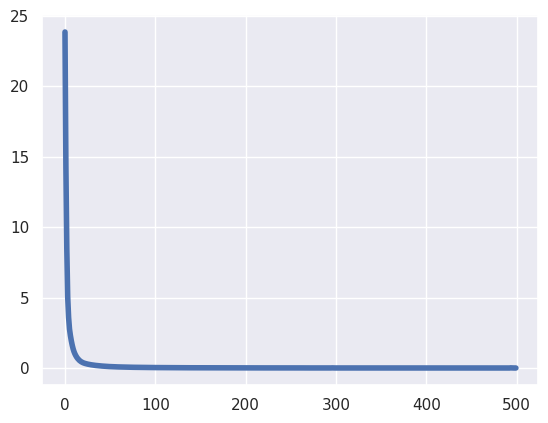

In [8]:
import seaborn as sns
sns.set_theme()
sns.lineplot(x=range(len(losses)), y=losses, lw=4)

In [9]:
def generate_scores(net, num_samples):
    xs, (As, Bs) = generate_data(num_samples=num_samples)
    A_hat, B_hat = net(xs)

    # xs, Cs = generate_data(num_samples=num_samples)
    # C_hats = net(xs).cpu().detach().numpy()

    C = torch.cat([As, Bs], axis=-1).cpu().detach().numpy()
    C_hat = torch.cat([A_hat, B_hat], axis=-1).cpu().detach().numpy()
    diff = C - C_hat
    return (C, C_hat), np.linalg.norm(diff, ord=2, axis=(1,2))

In [10]:
N_cal, N_test = 200, 200
(cal_C, cal_C_hat),   cal_scores  = generate_scores(net, num_samples=N_cal)
(test_C, test_C_hat), test_scores = generate_scores(net, num_samples=N_test)

In [11]:
alpha = 0.05
q_hat = np.quantile(cal_scores, q = 1-alpha)
coverage = np.sum(test_scores < q_hat) / N_test
print(f"Coverage: {coverage}")

Coverage: 0.97


In [13]:
with open("experiments/airfoil.pkl", "wb") as f:
    pickle.dump({
        "test_C": test_C, 
        "test_C_hat": test_C_hat,
        "q_hat": q_hat,
    }, f)